### Helmholz

In [2]:
import numpy as np
import numpy.matlib as matlib
import matplotlib.pyplot as plt
import polars as pl
from tmm.tmm import TMM
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

data = pl.read_csv("lp_media_medicao1.csv")

class TMM(TMM):
    def helmholtz_layer(self, t=100, d=10, v_radius=100, method="eq_fluid", layer=None):
        """
        Adds layer representing a Helmholtz ressonator to the existing device. 

        Parameters
        ----------
        t : float or int, optional
            Width of the ressonator bottleneck [mm]
        d : int or float
            Bottleneck diameter [mm]
        v_radius: int or float
            Volume radius of the ressonator cavity [mm]
        method : string, optional
            Chooses between the available methods to calculate resistive losses.
        layer : None or int, optional
            Optional value to choose the layer level. If None is passed the layer will be adding to the existing ones.
        """

        # Adjusting units
        t_meters = t / 1000
        d_meters = d / 1000
        v_radius_meters = v_radius / 1000
        v = (4/3)*np.pi*v_radius_meters**3
        bottleneck_area = np.pi*(d_meters**2) / 4 
        t_corr = t_meters + 0.85*(d_meters/2) # equivalent length
        rm = 0
        if method is None: # no losses, so expected absorption is zero
            kc = np.sqrt(self.k0 ** 2 - self.k0 ** 2 * np.sin(np.deg2rad(self.incidence_angle)))
            rho_c = self.rho0
        elif method == "eq_fluid": # Zwikker and Kosten viscothermic losses
            kc, zc = self.viscothermal_circular(d_meters, open_area=1)
            rho_c = (zc*self.w0) / (kc * (self.c0)**2)
        elif method == "ingard": # additional Rm term to account for losses
            kc = np.sqrt(self.k0 ** 2 - self.k0 ** 2 * np.sin(np.deg2rad(self.incidence_angle)))
            rho_c = self.rho0
            rm = 0.00166*np.sqrt(self.freq) * ((t_corr + 0.5*d_meters) / (self.rho0*self.c0*0.5*d_meters)) + ((self.rho0*self.c0*self.k0**2 * bottleneck_area) / (2*np.pi))
        else:
            raise AttributeError("method not available.")

        # Helmholtz ressonator impedance
        zr = rm + 1j * (self.c0*kc*rho_c*t_corr - ((rho_c*(self.c0)**2 * bottleneck_area) / (v*self.c0*kc)))
    
        zr = matlib.repmat(zr, len(self.incidence_angle), 1).T
        ones = np.ones_like(self.freq, shape=(len(self.freq), len(self.incidence_angle)))
        zeros = np.zeros_like(self.freq, shape=(len(self.freq), len(self.incidence_angle)))

        # create parallel ressonator matrix 
        Ta = np.array([[ones, zeros],
                        [bottleneck_area / zr, ones]])

        if layer is None:
            layer = len(self.matrix)

        self.matrix[layer] = {"type": "helmholtz_layer",
                              "thickness [mm]": t,
                              "tube_diameter [mm]": d,
                              "volume_radius [mm]": v_radius,
                              "matrix": Ta,
                              }

In [3]:
helmholtz = TMM(fmin=100, fmax=9200, df=1, incidence="normal", filename="helmholtz")
# specify device front termination area
helmholtz.s0 = 0.1

helmholtz.helmholtz_layer(t=100, d=32, v_radius=70, method="eq_fluid")

# Compute, plot and export data
helmholtz.compute(rigid_backing=True, show_layers=True)
helmholtz.save2sheet(n_oct=3)
helmholtz.save()
bands, filtered_alpha = helmholtz.filter_alpha(view=False, n_oct=3)

Device properties:
	(1 - Front face)
	(2 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  helmholtz_layer
	thickness [mm]: 100.00 | thickness [inches]: 3.94
	tube_diameter [mm]: 32.00 | tube_diameter [inches]: 1.26
	volume_radius [mm]: 70.00 | volume_radius [inches]: 2.76
Layer 2:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 100.00 | Total treatment depth [inches]: 3.94
Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/helmholtz.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/helmholtz.h5


### Placa perfurada

Device properties:
	(1 - Front face)
	(4 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  perforated_panel_layer
	thickness [mm]: 30.00 | thickness [inches]: 1.18
	hole_diameter [mm]: 5.00 | hole_diameter [inches]: 0.20
	hole_spacing [mm]: 20.00 | hole_spacing [inches]: 0.79
	open_area [%]: 4.91
	end_correction:  jb
	rho [kg/m3]: None
	method:  eq_fluid
Layer 2:
	type:  porous_layer
	flow_resistivity [k*Pa*s/m²]: 27.00
	thickness [mm]: 50.00 | thickness [inches]: 1.97
	model:  mac
Layer 3:
	type:  air_layer
	thickness [mm]: 50.00 | thickness [inches]: 1.97
Layer 4:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 130.00 | Total treatment depth [inches]: 5.12
Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_1.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_1.h5


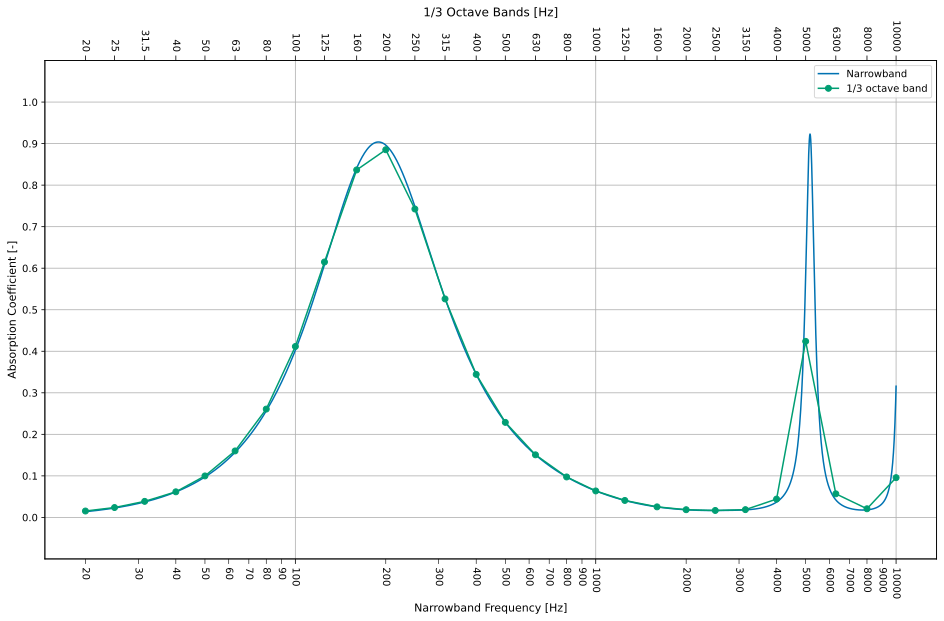

In [4]:
# Define the frequency range, resolution and sound incidence
perforated_panel_1 = TMM(fmin=20, fmax=10000, df=1, incidence="normal", filename="placa_perfurada_1")

# Define the layers - from top to bottom
perforated_panel_1.perforated_panel_layer(t=30, d=5, s=20, method="eq_fluid") # Use Zwikker&Kosten method
perforated_panel_1.porous_layer(model="mac", t=50, sigma=27) # Allard-Champoux model
perforated_panel_1.air_layer(t=50)

# Compute, plot and export data
perforated_panel_1.compute(rigid_backing=True, show_layers=True)
# perforated_panel_1.plot(plots=["alpha"], save_fig=True)
perforated_panel_1.save2sheet(n_oct=3)
perforated_panel_1.save()
bands, filtered_alpha = perforated_panel_1.filter_alpha(view=True, n_oct=3)

Device properties:
	(1 - Front face)
	(4 - Rear Face)
	Sound incidence: normal
	Angle: 0°

Layer 1:
	type:  perforated_panel_layer
	thickness [mm]: 20.00 | thickness [inches]: 0.79
	hole_diameter [mm]: 8.00 | hole_diameter [inches]: 0.31
	hole_spacing [mm]: 15.00 | hole_spacing [inches]: 0.59
	open_area [%]: 22.34
	end_correction:  jb
	rho [kg/m3]: None
	method:  eq_fluid
Layer 2:
	type:  porous_layer
	flow_resistivity [k*Pa*s/m²]: 27.00
	thickness [mm]: 50.00 | thickness [inches]: 1.97
	model:  mac
Layer 3:
	type:  air_layer
	thickness [mm]: 50.00 | thickness [inches]: 1.97
Layer 4:
	type:  backing
	rigid_backing:  True
	impedance_conjugate:  False

Total treatment depth [mm]: 120.00 | Total treatment depth [inches]: 4.72
Sheet saved to  /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_2.xlsx
HDF5 file saved at /home/will/Documents/UFSM/6o semestre/Controle de ruído/controle_de_ruido/Treatments/placa_perfurada_2.h5


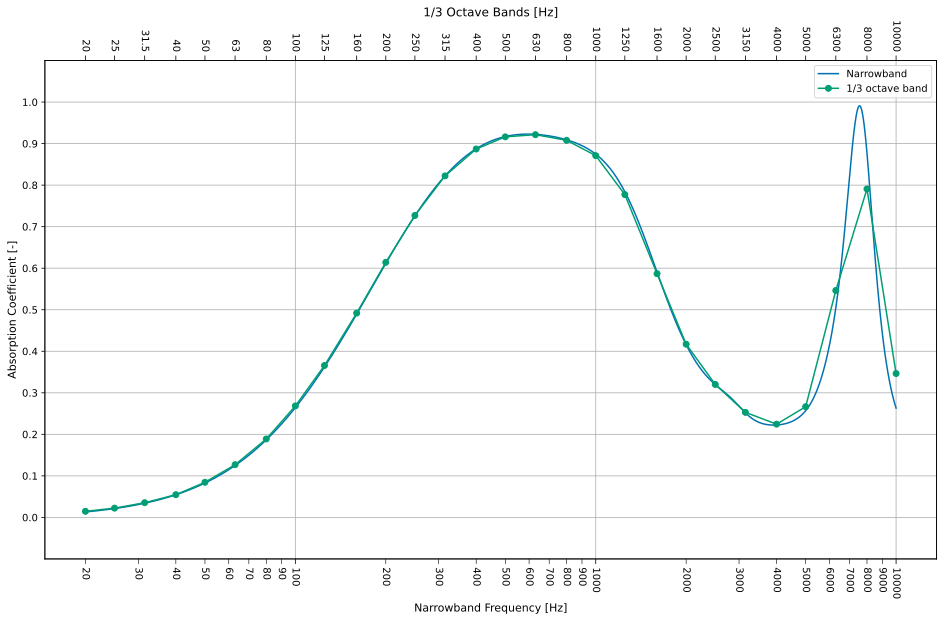

In [5]:
# Define the frequency range, resolution and sound incidence
perforated_panel_2 = TMM(fmin=20, fmax=10000, df=1, incidence="normal", filename="placa_perfurada_2")

# Define the layers - from top to bottom
perforated_panel_2.perforated_panel_layer(t=20, d=8, s=15, method="eq_fluid") # Use Zwikker&Kosten method
perforated_panel_2.porous_layer(model="mac", t=50, sigma=27) # Allard-Champoux model
perforated_panel_2.air_layer(t=50)

# Compute, plot and export data
perforated_panel_2.compute(rigid_backing=True, show_layers=True)
# perforated_panel_2.plot(plots=["alpha"], save_fig=True)
perforated_panel_2.save2sheet(n_oct=3)
perforated_panel_2.save()
bands, filtered_alpha = perforated_panel_2.filter_alpha(view=True, n_oct=3)

### Amortecedor de vibrações

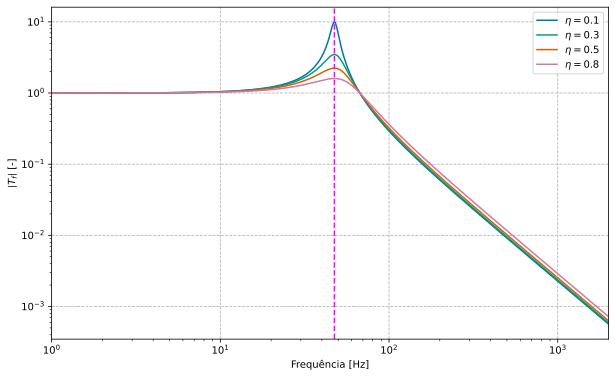

In [6]:
m = 0.265 # mass [kg]
E = 1e6 # young's modulus [Pa]
d = 0.03 # diameter [m]
A = (np.pi*d**2) / 4 # area [m^2]
L = 0.03 # width [m] 
k= (E*A) / L# stiffness [N/m]

etas = np.array([0.1, 0.3, 0.5, 0.8]) # loss factor

w_n=np.sqrt(k/m) # natural frequecy [rad/s]
freq = np.arange(1, 2000, 1)
w=2*np.pi*freq

fig, ax = plt.subplots(figsize=(10, 6))
for eta in etas:
    kc = k*(1 + 1j*eta)
    Tf= np.abs(kc / (kc - w**2 * m))
    ax.loglog(freq, Tf, label=rf"$\eta = {eta}$")

ax.grid(linestyle = '--', which='major')
ax.set_xlabel('Frequência [Hz]')
ax.set_ylabel(r'$\left|T_f\right|$ [-]')
ax.set_xlim((freq[0], freq[-1]))
ax.axvline(x=(w_n/(2*np.pi)), linestyle="--", color="magenta")
ax.legend()
plt.show()

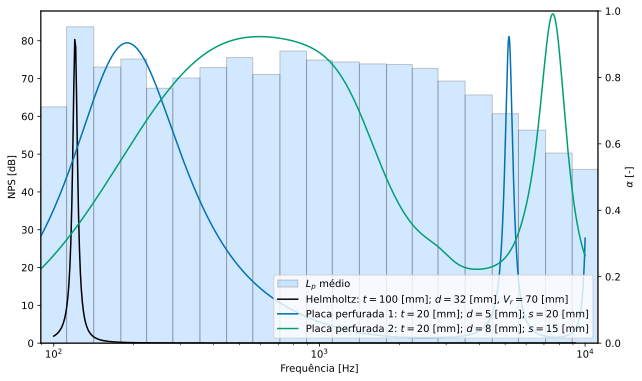

In [118]:
fig, ax = plt.subplots(figsize=(10, 6))

x = data.select("f").to_numpy().flatten()
height = data.select("NPS").to_numpy().flatten()

edges_between_points = np.sqrt(x[:-1] * x[1:])
log_x = np.log(x)
first_edge_dist = (log_x[1] - log_x[0]) / 2
last_edge_dist = (log_x[-1] - log_x[-2]) / 2
first_edge = np.exp(log_x[0] - first_edge_dist)
last_edge = np.exp(log_x[-1] + last_edge_dist)
all_edges = np.concatenate(([first_edge], edges_between_points, [last_edge]))
widths = np.diff(all_edges)
left_edges = all_edges[:-1]

plt.bar(left_edges, height, width=widths, align='edge',
        facecolor='dodgerblue', edgecolor='black', lw=1, label="$L_p$ médio", alpha=0.2)
ax.set_xscale("log")
ax.set_ylabel(r'NPS [dB]')
ax.set_xlabel('Frequência [Hz]')
ax.set_xlim((all_edges[0], all_edges[-1]))

ax2 = ax.twinx()
ax2.semilogx(helmholtz.freq, helmholtz.alpha, c="k", label=r"Helmholtz: $t=100$ [mm]; $d=32$ [mm], $V_r=70$ [mm]")
ax2.semilogx(perforated_panel_1.freq, perforated_panel_1.alpha, label="Placa perfurada 1: $t=20$ [mm]; $d=5$ [mm]; $s=20$ [mm]")
ax2.semilogx(perforated_panel_2.freq, perforated_panel_2.alpha, label="Placa perfurada 2: $t=20$ [mm]; $d=8$ [mm]; $s=15$ [mm]")

ax2.set_ylim(0, 1)
ax2.set_ylabel(r"$\alpha$ [-]")

fig.legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax.transAxes)
plt.show()